In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import collections
import importlib
from typing import Sequence, Tuple, List, Optional
from tracker import extractor, utils, metrics, visuals
np.set_printoptions(threshold=np.nan)
np.set_printoptions(linewidth=np.nan)

In [105]:
importlib.reload(metrics)

<module 'tracker.metrics' from 'E:\\SystemHDD\\Career\\Fermilab\\Fermi-Internship-2017\\Track\\tracker\\metrics.py'>

In [37]:
%%time
frame  = pd.read_csv("data/sets/RAMP-10N-25T-3600E-235R.gz")
events = utils.list_of_groups(frame, "event_id")
events = sorted([e.sort_values("cluster_id") for e in events], key=(lambda event: len(event)))

Wall time: 2.15 s


In [107]:
crosses = []
for i, event in enumerate(events):
    print(i)
    crosses.append(metrics.number_of_crossings(event))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


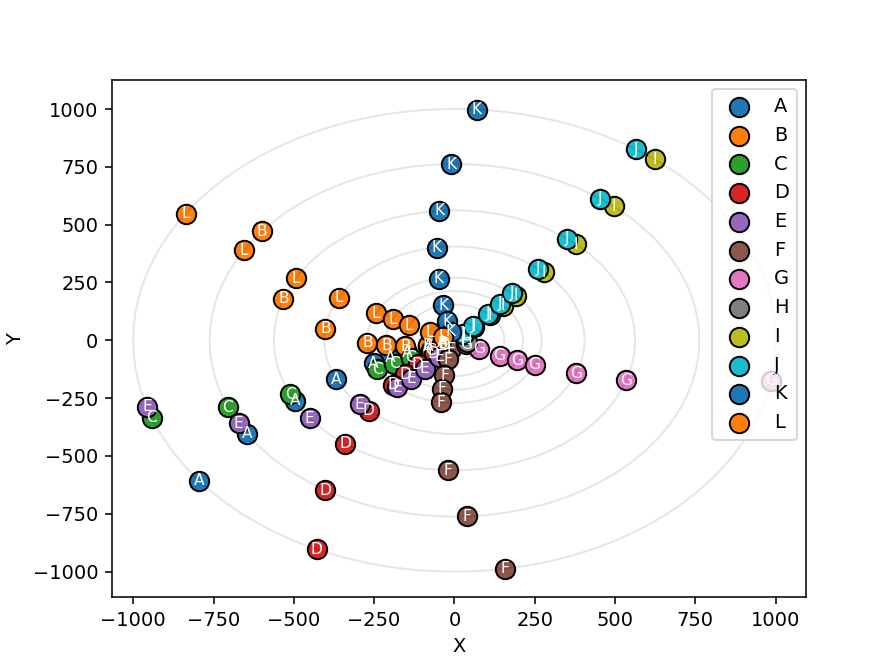

In [104]:
visuals.Plot2D(utils.remove_padding(utils.remove_noise(events[n])), order=["phi", "r", "z"]).plot(mode="xy")

In [ ]:
def cartesian(position: np.ndarray, order: List[str]) -> np.ndarray:
    phi, r, z = [position[order.index(s)] for s in ["phi", "r", "z"]]
    return np.array([(np.cos(phi) * r), (np.sin(phi) * r), z])

def groupby(array: np.ndarray) -> List[List[float]]:
    D = dict((value, index) for (index, value) in enumerate(np.unique(array)))
    L = [[] for _ in range(len(D))]
    for index, value in enumerate(array):
        L[D[value]].append(index)
    return L



In [ ]:
def circle_circle_intersection(
        p0 : np.ndarray,  # The center of the first circle.
        r0 : float,       # The radius of the first circle.
        p1 : np.ndarray,  # The center of the second circle.
        r1 : float,       # The radius of the second circle.
        ) -> Tuple[np.ndarray, np.ndarray]:  # Two points of intersection.
    d  = np.linalg.norm(p0 - p1)
    a  = (r0 * r0 - r1 * r1 + d * d) / (2 * d)
    h  = np.sqrt(r0 * r0 - a * a)
    p2 = (p1 - p0) * (a / d) + p0
    x3 = p2[0] + h * (p1[1] - p0[1]) / d
    y3 = p2[1] - h * (p1[0] - p0[0]) / d
    x4 = p2[0] - h * (p1[1] - p0[1]) / d
    y4 = p2[1] + h * (p1[0] - p0[0]) / d
    return np.array([x3, y3]), np.array([x4, y4])

def circle_line_intersection(
        p0 : np.ndarray,  # The position (xy) of the ray's starting point.
        p1 : np.ndarray,  # The position (xy) of the ray's guiding point.
        p2 : np.ndarray,  # The position (xy) of the center of the circle.
        r  : float,       # The radius of the circle.
        ) -> Optional[np.ndarray]:  # The first point of intersection or None if no intersection.
    v = p1 - p0
    a = v.dot(v)
    b = 2 * v.dot(p0 - p2)
    c = p0.dot(p0) + p2.dot(p2) - 2 * p0.dot(p2) - r**2
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:  # Test for negative discriminant.
        return None  # If discriminant is negative, then no solution.
    t = (-b + np.sqrt(discriminant)) / (2 * a)
    return p0 + t * v

def tighten_bounds(bounds1: Tuple[float, float], bounds2: Tuple[float, float]) -> Tuple[float, float]:
    if bounds1 == (0, 2 * np.pi):
        return bounds2
    if bounds2 == (0, 2 * np.pi):
        return bounds1
    b1 = bounds1[0] if phi_lies_within_bounds(bounds2[0], bounds1) else bounds2[0]
    b2 = bounds1[1] if phi_lies_within_bounds(bounds2[1], bounds1) else bounds2[1]
    return b1, b2

def phi_lies_within_bounds(phi: float, bounds: Tuple[float, float]) -> bool:
    phi = phi % (2 * np.pi)
    b1  = bounds[0] % (2 * np.pi)
    b2  = bounds[1] % (2 * np.pi)
    return (b1 <= phi or phi <= b2) if (b1 > b2) else (b1 <= phi and phi <= b2)

def phi_bounds_from_circle(xyz: np.ndarray, radius: float) -> Tuple[float, float]:
    center = xyz[:2] / 2
    b0, b1 = circle_circle_intersection(center, np.linalg.norm(center), np.array([0, 0]), radius)
    return  np.arctan2(b1[1], b1[0]), np.arctan2(b0[1], b0[0])

def phi_bounds_from_lines(super_xyz: np.ndarray, sub_xyz: np.ndarray, radius: float) -> Tuple[float, float]:
    super_phi = np.arctan2(super_xyz[1], super_xyz[0])
    sub_phi   = np.arctan2(  sub_xyz[1],   sub_xyz[0])
    intersect = circle_line_intersection(super_xyz[:2], sub_xyz[:2], np.array([0, 0]), radius)
    if intersect is not None:
        bounds2 = np.arctan2(intersect[1], intersect[0])
        if phi_lies_within_bounds(0, (sub_phi, super_phi)):
            return (bounds2, sub_phi)
        else:
            return (sub_phi, bounds2)
    else:
        if phi_lies_within_bounds(0, (sub_phi, super_phi)):
            return (sub_phi - np.pi / 2, sub_phi)
        else:
            return (sub_phi, sub_phi + np.pi / 2)

In [ ]:
print(phi_bounds_from_lines(np.array((10, 10)), np.array((8, 5)), 8))

In [3]:
%%time
frame  = pd.read_csv("data/sets/RAMP-10N-25T-3600E-235R.gz")
frame  = utils.remove_padding(utils.remove_noise(frame))
frame  = frame.groupby(["event_id", "cluster_id"]).filter(lambda group: len(group) == 9)
events = utils.list_of_groups(frame, "event_id")
events = sorted(events, key=(lambda event: len(event)))

Wall time: 4.89 s
Compiler : 174 ms


In [4]:
order     = ["phi", "r", "z"]
number    = 701
print("Hits:   {}".format(metrics.number_of_hits(events[number])))
print("Tracks: {}".format(metrics.number_of_tracks(events[number])))
positions = extractor.extract_input(events[number], order)
tracks    = extractor.extract_output(events[number], order, categorical=False)

Hits:   36
Tracks: 4


In [ ]:
G = nx.DiGraph()
for idx, position in enumerate(positions):
    G.add_node(
        n=idx,
        cartesian=cartesian(position, order)[:2],
        phi=position[order.index("phi")],
        r=position[order.index("r")],
        z=position[order.index("z")]
    )
nodes    = G.nodes(data=True)
radiuses = groupby(positions[:, order.index("r")])
print(radiuses)

In [ ]:
def connect( 
        radiuses_index : int, 
        parents        : List[int],
        ) -> List[int]:
      # 1D array
    bounds     = (0, 2 * np.pi)
    candidates = radiuses[radiuses_index]  # List[int]
    radius     = nodes[candidates[0]][1]["r"]
    
    for parent_index in parents:
        cartesian = nodes[parent_index][1]["cartesian"]
        bounds    = tighten_bounds(bounds, phi_bounds_from_circle(cartesian, radius))
    if len(parents) > 1:
        c1 = nodes[parents[-1]][1]["cartesian"]
        c2 = nodes[parents[-2]][1]["cartesian"]
        bounds = tighten_bounds(bounds, phi_bounds_from_lines(c1, c2, radius))

    accepted = []
    for i in candidates:
        node = nodes[i][1]
        phi  = node["phi"]
        if phi_lies_within_bounds(phi, bounds):
            if radiuses_index <= 0:
                accepted.append((parents[-1], i))
            else:
                next_branches = connect(radiuses_index - 1, parents + [i])
                if next_branches:
                    accepted += next_branches + [(parents[-1], i)]
    return accepted

for i in radiuses[-1]:
    G.add_edges_from(connect(len(radiuses) - 2, [i]))
    break
G.add_node(n=-1, cartesian=np.array([0, 0]), phi=np.NaN, r=-1, z=0)

In [ ]:
ax = plt.subplot(111)
for radius in np.unique(frame["r"]):
    ax.add_artist(plt.Circle((0, 0), radius, color="black", alpha=0.1, fill=False))
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)
nx.draw_networkx(
    G=G,
    pos=nx.get_node_attributes(G, "cartesian"),
    ax=ax,
    node_size=200, 
    node_color="blue", 
    edge_color="purple", 
    alpha=.3,
    #style="dashed",
    font_color="black"
)